In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['OPENBLAS_NUM_THREAD'] = '1'

In [2]:
device = 'cuda'

In [3]:
%run training.ipynb

In [4]:
import torch.nn.init as nn_init
import math

In [5]:
def reglu(x: Tensor) -> Tensor:
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)
    
class ReGLU(nn.Module):
    def forward(self, x: Tensor) -> Tensor:
        return reglu(x)

def get_activation_fn(name: str) -> ty.Callable[[Tensor], Tensor]:
    return (
        reglu
        if name == 'reglu'
        else geglu
        if name == 'geglu'
        else torch.sigmoid
        if name == 'sigmoid'
        else getattr(F, name)
    )


def get_nonglu_activation_fn(name: str) -> ty.Callable[[Tensor], Tensor]:
    return (
        F.relu
        if name == 'reglu'
        else F.gelu
        if name == 'geglu'
        else get_activation_fn(name)
    )

In [6]:
class Tokenizer(nn.Module):
    category_offsets: ty.Optional[Tensor]

    def __init__(
        self,
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        d_token: int,
        bias: bool,
    ) -> None:
        super().__init__()
        if categories is None:
            d_bias = d_numerical
            self.category_offsets = None
            self.category_embeddings = None
        else:
            d_bias = d_numerical + len(categories)
            category_offsets = torch.tensor([0] + categories[:-1]).cumsum(0)
            self.register_buffer('category_offsets', category_offsets)
            self.category_embeddings = nn.Embedding(sum(categories), d_token)
            nn_init.kaiming_uniform_(self.category_embeddings.weight, a=math.sqrt(5))
            print(f'{self.category_embeddings.weight.shape=}')

        # take [CLS] token into account
        self.weight = nn.Parameter(Tensor(d_numerical + 1, d_token))
        self.bias = nn.Parameter(Tensor(d_bias, d_token)) if bias else None
        # The initialization is inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight) + (
            0 if self.category_offsets is None else len(self.category_offsets)
        )

    def forward(self, x_num: Tensor, x_cat: ty.Optional[Tensor]) -> Tensor:
        x_some = x_num if x_cat is None else x_cat
        assert x_some is not None
        x_num = torch.cat(
            [torch.ones(len(x_some), 1, device=x_some.device)]  # [CLS]
            + ([] if x_num is None else [x_num]),
            dim=1,
        )
        x = self.weight[None] * x_num[:, :, None]
        if x_cat is not None:
            x = torch.cat(
                [x, self.category_embeddings(x_cat + self.category_offsets[None])],
                dim=1,
            )
        if self.bias is not None:
            bias = torch.cat(
                [
                    torch.zeros(1, self.bias.shape[1], device=x.device),
                    self.bias,
                ]
            )
            x = x + bias[None]
        return x


class MultiheadAttention(nn.Module):
    def __init__(
        self, d: int, n_heads: int, dropout: float, initialization: str
    ) -> None:
        if n_heads > 1:
            assert d % n_heads == 0
        assert initialization in ['xavier', 'kaiming']

        super().__init__()
        self.W_q = nn.Linear(d, d)
        self.W_k = nn.Linear(d, d)
        self.W_v = nn.Linear(d, d)
        self.W_out = nn.Linear(d, d) if n_heads > 1 else None
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout) if dropout else None

        for m in [self.W_q, self.W_k, self.W_v]:
            if initialization == 'xavier' and (n_heads > 1 or m is not self.W_v):
                # gain is needed since W_qkv is represented with 3 separate layers
                nn_init.xavier_uniform_(m.weight, gain=1 / math.sqrt(2))
            nn_init.zeros_(m.bias)
        if self.W_out is not None:
            nn_init.zeros_(self.W_out.bias)

    def _reshape(self, x: Tensor) -> Tensor:
        batch_size, n_tokens, d = x.shape
        d_head = d // self.n_heads
        return (
            x.reshape(batch_size, n_tokens, self.n_heads, d_head)
            .transpose(1, 2)
            .reshape(batch_size * self.n_heads, n_tokens, d_head)
        )

    def forward(
        self,
        x_q: Tensor,
        x_kv: Tensor,
        key_compression: ty.Optional[nn.Linear],
        value_compression: ty.Optional[nn.Linear],
    ) -> Tensor:
        q, k, v = self.W_q(x_q), self.W_k(x_kv), self.W_v(x_kv)
        for tensor in [q, k, v]:
            assert tensor.shape[-1] % self.n_heads == 0
        if key_compression is not None:
            assert value_compression is not None
            k = key_compression(k.transpose(1, 2)).transpose(1, 2)
            v = value_compression(v.transpose(1, 2)).transpose(1, 2)
        else:
            assert value_compression is None

        batch_size = len(q)
        d_head_key = k.shape[-1] // self.n_heads
        d_head_value = v.shape[-1] // self.n_heads
        n_q_tokens = q.shape[1]

        q = self._reshape(q)
        k = self._reshape(k)
        attention = F.softmax(q @ k.transpose(1, 2) / math.sqrt(d_head_key), dim=-1)
        if self.dropout is not None:
            attention = self.dropout(attention)
        x = attention @ self._reshape(v)
        x = (
            x.reshape(batch_size, self.n_heads, n_q_tokens, d_head_value)
            .transpose(1, 2)
            .reshape(batch_size, n_q_tokens, self.n_heads * d_head_value)
        )
        if self.W_out is not None:
            x = self.W_out(x)
        return x


class Transformer(nn.Module):
    """Transformer.

    References:
    - https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
    - https://github.com/facebookresearch/pytext/tree/master/pytext/models/representations/transformer
    - https://github.com/pytorch/fairseq/blob/1bba712622b8ae4efb3eb793a8a40da386fe11d0/examples/linformer/linformer_src/modules/multihead_linear_attention.py#L19
    """

    def __init__(
        self,
        *,
        # tokenizer
        d_numerical: int,
        categories: ty.Optional[ty.List[int]],
        token_bias: bool,
        # transformer
        n_layers: int,
        d_token: int,
        n_heads: int,
        d_ffn_factor: float,
        attention_dropout: float,
        ffn_dropout: float,
        residual_dropout: float,
        activation: str,
        prenormalization: bool,
        initialization: str,
        # linformer
        kv_compression: ty.Optional[float],
        kv_compression_sharing: ty.Optional[str],
        #
        d_out: int,
    ) -> None:
        assert (kv_compression is None) ^ (kv_compression_sharing is not None)

        super().__init__()
        self.tokenizer = Tokenizer(d_numerical, categories, d_token, token_bias)
        n_tokens = self.tokenizer.n_tokens

        def make_kv_compression():
            assert kv_compression
            compression = nn.Linear(
                n_tokens, int(n_tokens * kv_compression), bias=False
            )
            if initialization == 'xavier':
                nn_init.xavier_uniform_(compression.weight)
            return compression

        self.shared_kv_compression = (
            make_kv_compression()
            if kv_compression and kv_compression_sharing == 'layerwise'
            else None
        )

        def make_normalization():
            return nn.LayerNorm(d_token)

        d_hidden = int(d_token * d_ffn_factor)
        self.layers = nn.ModuleList([])
        for layer_idx in range(n_layers):
            layer = nn.ModuleDict(
                {
                    'attention': MultiheadAttention(
                        d_token, n_heads, attention_dropout, initialization
                    ),
                    'linear0': nn.Linear(
                        d_token, d_hidden * (2 if activation.endswith('glu') else 1)
                    ),
                    'linear1': nn.Linear(d_hidden, d_token),
                    'norm1': make_normalization(),
                }
            )
            if not prenormalization or layer_idx:
                layer['norm0'] = make_normalization()
            if kv_compression and self.shared_kv_compression is None:
                layer['key_compression'] = make_kv_compression()
                if kv_compression_sharing == 'headwise':
                    layer['value_compression'] = make_kv_compression()
                else:
                    assert kv_compression_sharing == 'key-value'
            self.layers.append(layer)

        self.activation = get_activation_fn(activation)
        self.last_activation = get_nonglu_activation_fn(activation)
        self.prenormalization = prenormalization
        self.last_normalization = make_normalization() if prenormalization else None
        self.ffn_dropout = ffn_dropout
        self.residual_dropout = residual_dropout
        self.head = nn.Linear(d_token, d_out)

    def _get_kv_compressions(self, layer):
        return (
            (self.shared_kv_compression, self.shared_kv_compression)
            if self.shared_kv_compression is not None
            else (layer['key_compression'], layer['value_compression'])
            if 'key_compression' in layer and 'value_compression' in layer
            else (layer['key_compression'], layer['key_compression'])
            if 'key_compression' in layer
            else (None, None)
        )

    def _start_residual(self, x, layer, norm_idx):
        x_residual = x
        if self.prenormalization:
            norm_key = f'norm{norm_idx}'
            if norm_key in layer:
                x_residual = layer[norm_key](x_residual)
        return x_residual

    def _end_residual(self, x, x_residual, layer, norm_idx):
        if self.residual_dropout:
            x_residual = F.dropout(x_residual, self.residual_dropout, self.training)
        x = x + x_residual
        if not self.prenormalization:
            x = layer[f'norm{norm_idx}'](x)
        return x

    def forward(self, x_num: Tensor, x_cat: ty.Optional[Tensor]) -> Tensor:
        x = self.tokenizer(x_num, x_cat)

        for layer_idx, layer in enumerate(self.layers):
            is_last_layer = layer_idx + 1 == len(self.layers)
            layer = ty.cast(ty.Dict[str, nn.Module], layer)

            x_residual = self._start_residual(x, layer, 0)
            x_residual = layer['attention'](
                # for the last attention, it is enough to process only [CLS]
                (x_residual[:, :1] if is_last_layer else x_residual),
                x_residual,
                *self._get_kv_compressions(layer),
            )
            if is_last_layer:
                x = x[:, : x_residual.shape[1]]
            x = self._end_residual(x, x_residual, layer, 0)

            x_residual = self._start_residual(x, layer, 1)
            x_residual = layer['linear0'](x_residual)
            x_residual = self.activation(x_residual)
            if self.ffn_dropout:
                x_residual = F.dropout(x_residual, self.ffn_dropout, self.training)
            x_residual = layer['linear1'](x_residual)
            x = self._end_residual(x, x_residual, layer, 1)

        assert x.shape[1] == 1
        x = x[:, 0]
        if self.last_normalization is not None:
            x = self.last_normalization(x)
        x = self.last_activation(x)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

In [60]:
train_params = {
    'batch_size' : 1024,
    'eval_batch_size' : 1024,
    'num_epochs' : 130,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

ft_transformer_params = {
    'd_numerical' : 27,
    'categories' : None,
    'token_bias' : True,
    'activation' : 'reglu',
    'attention_dropout' : 0.02124664264260197,
    'd_ffn_factor' : 2.007965840708826,
    'd_token' : 512,
    'ffn_dropout' : 0.1825150176311774,
    'initialization' : 'kaiming',
    'n_heads' : 8,
    'n_layers' : 2,
    'prenormalization' : True,
    'd_out' : 100,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 1.417693328068533e-05,
    'weight_decay' : 5.155695735419175e-05
}

catboost_params = {
    'bagging_temperature' : 0.6788373487088936,
    'depth' : 5,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 3.066893023126909,
    'leaf_estimation_iterations' : 10,
    'learning_rate' : 0.04324396670696182,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

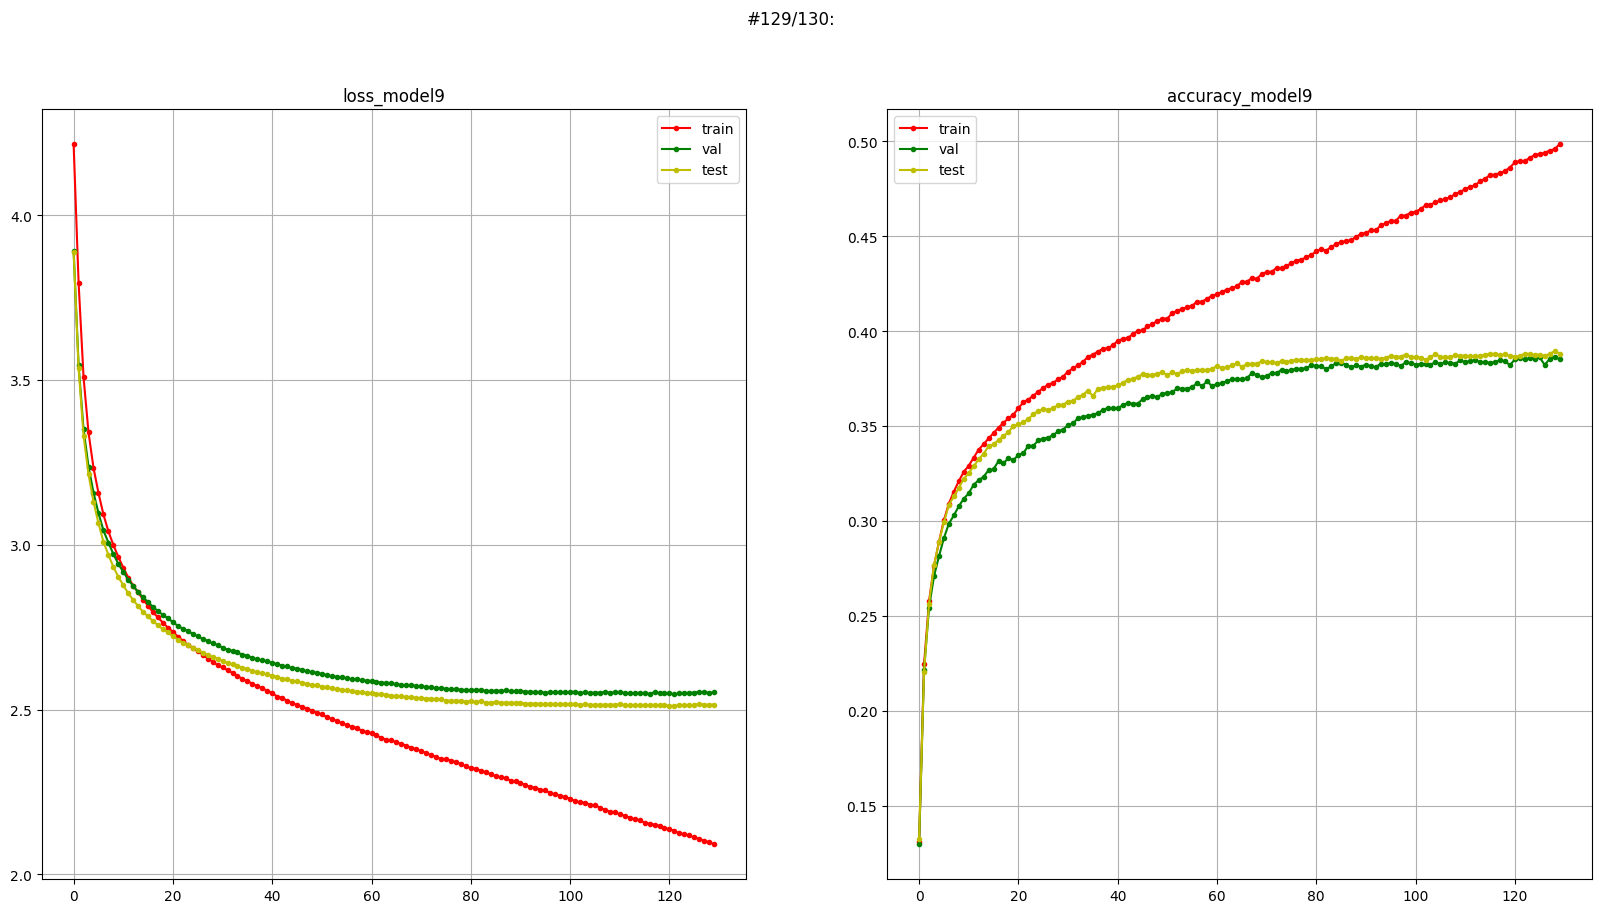

100%|█████████████████████████████████████████| 130/130 [18:17<00:00,  8.45s/it]


0:	learn: 0.1719154	test: 0.1664110	best: 0.1664110 (0)	total: 152ms	remaining: 5m 3s
10:	learn: 0.2085850	test: 0.2016871	best: 0.2017830 (7)	total: 1.85s	remaining: 5m 35s
20:	learn: 0.2452545	test: 0.2358129	best: 0.2358129 (20)	total: 5.04s	remaining: 7m 54s
30:	learn: 0.2609529	test: 0.2488497	best: 0.2488497 (30)	total: 8.34s	remaining: 8m 49s
40:	learn: 0.2727447	test: 0.2618865	best: 0.2618865 (40)	total: 11.8s	remaining: 9m 23s
50:	learn: 0.2842249	test: 0.2707055	best: 0.2707055 (50)	total: 15.3s	remaining: 9m 44s
60:	learn: 0.2952737	test: 0.2781825	best: 0.2781825 (60)	total: 18.9s	remaining: 9m 59s
70:	learn: 0.3039018	test: 0.2829755	best: 0.2829755 (70)	total: 22.4s	remaining: 10m 9s
80:	learn: 0.3126019	test: 0.2926572	best: 0.2926572 (80)	total: 26s	remaining: 10m 17s
90:	learn: 0.3221647	test: 0.2996549	best: 0.2996549 (90)	total: 29.6s	remaining: 10m 21s
100:	learn: 0.3297383	test: 0.3031058	best: 0.3031058 (100)	total: 33.2s	remaining: 10m 24s
110:	learn: 0.3369763	

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.2578372	test: 0.2528758	best: 0.2528758 (0)	total: 135ms	remaining: 4m 29s
10:	learn: 0.3209664	test: 0.3153758	best: 0.3153758 (10)	total: 1.86s	remaining: 5m 36s
20:	learn: 0.3670310	test: 0.3651265	best: 0.3651265 (20)	total: 4.39s	remaining: 6m 54s
30:	learn: 0.4053303	test: 0.3987730	best: 0.3987730 (30)	total: 7.63s	remaining: 8m 4s
40:	learn: 0.4391477	test: 0.4285851	best: 0.4285851 (40)	total: 10.9s	remaining: 8m 39s
50:	learn: 0.4663263	test: 0.4541794	best: 0.4541794 (50)	total: 14.1s	remaining: 8m 59s
60:	learn: 0.4908206	test: 0.4757477	best: 0.4757477 (60)	total: 17.4s	remaining: 9m 13s
70:	learn: 0.5142364	test: 0.4974118	best: 0.4974118 (70)	total: 20.7s	remaining: 9m 23s
80:	learn: 0.5348960	test: 0.5143788	best: 0.5143788 (80)	total: 24s	remaining: 9m 29s
90:	learn: 0.5544051	test: 0.5285660	best: 0.5285660 (90)	total: 27.4s	remaining: 9m 33s
100:	learn: 0.5707746	test: 0.5392063	best: 0.5392063 (100)	total: 30.7s	remaining: 9m 37s
110:	learn: 0.5854424	te

 20%|████████▊                                   | 1/5 [10:57<43:49, 657.39s/it]

0:	learn: 0.2223900	test: 0.2134778	best: 0.2134778 (0)	total: 164ms	remaining: 5m 26s
10:	learn: 0.2992522	test: 0.2999425	best: 0.2999425 (10)	total: 1.28s	remaining: 3m 51s
20:	learn: 0.3412185	test: 0.3422163	best: 0.3422163 (20)	total: 2.83s	remaining: 4m 26s
30:	learn: 0.3588103	test: 0.3598543	best: 0.3598543 (30)	total: 4.72s	remaining: 5m
40:	learn: 0.4014716	test: 0.4038535	best: 0.4038535 (40)	total: 8.02s	remaining: 6m 23s
50:	learn: 0.4383329	test: 0.4328988	best: 0.4328988 (50)	total: 11.4s	remaining: 7m 15s
60:	learn: 0.4663263	test: 0.4591641	best: 0.4591641 (60)	total: 14.8s	remaining: 7m 51s
70:	learn: 0.4907248	test: 0.4778566	best: 0.4778566 (70)	total: 18.3s	remaining: 8m 16s
80:	learn: 0.5131339	test: 0.4954946	best: 0.4954946 (80)	total: 21.7s	remaining: 8m 33s
90:	learn: 0.5335299	test: 0.5155291	best: 0.5155291 (90)	total: 25.1s	remaining: 8m 46s
100:	learn: 0.5516969	test: 0.5322086	best: 0.5322086 (100)	total: 28.6s	remaining: 8m 57s
110:	learn: 0.5697680	tes

 40%|█████████████████▌                          | 2/5 [22:18<33:34, 671.51s/it]

0:	learn: 0.2295322	test: 0.2255560	best: 0.2255560 (0)	total: 107ms	remaining: 3m 34s
10:	learn: 0.3152143	test: 0.3179640	best: 0.3179640 (10)	total: 1.17s	remaining: 3m 32s
20:	learn: 0.3268383	test: 0.3291794	best: 0.3291794 (20)	total: 2.34s	remaining: 3m 40s
30:	learn: 0.3437590	test: 0.3457630	best: 0.3457630 (30)	total: 3.8s	remaining: 4m 1s
40:	learn: 0.3731426	test: 0.3739456	best: 0.3739456 (40)	total: 5.93s	remaining: 4m 43s
50:	learn: 0.4041319	test: 0.4020322	best: 0.4020322 (50)	total: 8.99s	remaining: 5m 43s
60:	learn: 0.4429585	test: 0.4335698	best: 0.4335698 (60)	total: 12.3s	remaining: 6m 31s
70:	learn: 0.4698974	test: 0.4589724	best: 0.4589724 (70)	total: 15.6s	remaining: 7m 4s
80:	learn: 0.4953983	test: 0.4821702	best: 0.4821702 (80)	total: 18.9s	remaining: 7m 28s
90:	learn: 0.5171364	test: 0.5017255	best: 0.5017255 (90)	total: 22.3s	remaining: 7m 47s
100:	learn: 0.5362142	test: 0.5180215	best: 0.5180215 (100)	total: 25.7s	remaining: 8m 2s
110:	learn: 0.5557473	tes

 60%|██████████████████████████▍                 | 3/5 [33:15<22:09, 664.81s/it]

0:	learn: 0.2488016	test: 0.2399348	best: 0.2399348 (0)	total: 109ms	remaining: 3m 37s
10:	learn: 0.3155258	test: 0.3143213	best: 0.3143213 (10)	total: 1.33s	remaining: 4m 1s
20:	learn: 0.3434714	test: 0.3417370	best: 0.3417370 (20)	total: 2.5s	remaining: 3m 55s
30:	learn: 0.3549516	test: 0.3521856	best: 0.3521856 (30)	total: 3.95s	remaining: 4m 11s
40:	learn: 0.3892005	test: 0.3852569	best: 0.3852569 (40)	total: 6.14s	remaining: 4m 53s
50:	learn: 0.4249113	test: 0.4167945	best: 0.4167945 (50)	total: 9.45s	remaining: 6m 1s
60:	learn: 0.4561164	test: 0.4451687	best: 0.4451687 (60)	total: 12.7s	remaining: 6m 45s
70:	learn: 0.4828156	test: 0.4695169	best: 0.4695169 (70)	total: 16.1s	remaining: 7m 17s
80:	learn: 0.5093711	test: 0.4907975	best: 0.4907975 (80)	total: 19.4s	remaining: 7m 40s
90:	learn: 0.5311811	test: 0.5114072	best: 0.5114072 (90)	total: 22.8s	remaining: 7m 58s
100:	learn: 0.5514572	test: 0.5278949	best: 0.5278949 (100)	total: 26.1s	remaining: 8m 11s
110:	learn: 0.5683060	te

 80%|███████████████████████████████████▏        | 4/5 [44:23<11:05, 665.94s/it]

0:	learn: 0.2295082	test: 0.2213382	best: 0.2213382 (0)	total: 109ms	remaining: 3m 38s
10:	learn: 0.3026316	test: 0.3024348	best: 0.3024348 (9)	total: 1.24s	remaining: 3m 44s
20:	learn: 0.3383424	test: 0.3383819	best: 0.3383819 (20)	total: 2.81s	remaining: 4m 24s
30:	learn: 0.3759227	test: 0.3735621	best: 0.3735621 (30)	total: 5.31s	remaining: 5m 37s
40:	learn: 0.4212444	test: 0.4144939	best: 0.4144939 (40)	total: 8.67s	remaining: 6m 54s
50:	learn: 0.4490461	test: 0.4413344	best: 0.4413344 (50)	total: 12s	remaining: 7m 40s
60:	learn: 0.4765603	test: 0.4650115	best: 0.4650115 (60)	total: 15.4s	remaining: 8m 9s
70:	learn: 0.5029000	test: 0.4884011	best: 0.4884011 (70)	total: 18.7s	remaining: 8m 28s
80:	learn: 0.5271786	test: 0.5079563	best: 0.5079563 (80)	total: 22.1s	remaining: 8m 43s
90:	learn: 0.5465919	test: 0.5241564	best: 0.5241564 (90)	total: 25.5s	remaining: 8m 54s
100:	learn: 0.5654060	test: 0.5383436	best: 0.5383436 (100)	total: 28.9s	remaining: 9m 3s
110:	learn: 0.5807689	test

100%|████████████████████████████████████████████| 5/5 [55:32<00:00, 666.60s/it]


0:	learn: 0.2743505	test: 0.2707055	best: 0.2707055 (0)	total: 133ms	remaining: 4m 25s
10:	learn: 0.3199837	test: 0.3166219	best: 0.3166219 (10)	total: 1.75s	remaining: 5m 16s
20:	learn: 0.3744607	test: 0.3755752	best: 0.3755752 (20)	total: 4.18s	remaining: 6m 33s
30:	learn: 0.4186559	test: 0.4139187	best: 0.4139187 (30)	total: 7.36s	remaining: 7m 47s
40:	learn: 0.4514428	test: 0.4387462	best: 0.4388420 (39)	total: 10.6s	remaining: 8m 28s
50:	learn: 0.4772793	test: 0.4652032	best: 0.4652032 (50)	total: 13.9s	remaining: 8m 52s
60:	learn: 0.4991132	test: 0.4858129	best: 0.4858129 (60)	total: 17.2s	remaining: 9m 6s
70:	learn: 0.5235116	test: 0.5079563	best: 0.5079563 (70)	total: 20.5s	remaining: 9m 17s
80:	learn: 0.5428770	test: 0.5229103	best: 0.5229103 (80)	total: 23.8s	remaining: 9m 23s
90:	learn: 0.5635845	test: 0.5393021	best: 0.5393021 (90)	total: 27.1s	remaining: 9m 28s
100:	learn: 0.5808887	test: 0.5527224	best: 0.5527224 (100)	total: 30.5s	remaining: 9m 32s
110:	learn: 0.5950772	

In [61]:
dataset_folder = 'helena'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder)
results_models_learning = LearnNModels(9, Transformer, ft_transformer_params, optimizer_params, data_model, train_params, metric)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=5, ensemble_size=3)

In [62]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.3894171779141104
distill_0 : 0.3821319018404908 ---------> 0.3825920245398773
model_1_metric : 0.3925613496932515
distill_1 : 0.3821319018404908 ---------> 0.3832055214723926
model_2_metric : 0.39087423312883435
distill_2 : 0.3821319018404908 ---------> 0.3793711656441718
model_3_metric : 0.3898006134969325
distill_3 : 0.3821319018404908 ---------> 0.37975460122699384
model_4_metric : 0.3898006134969325
distill_4 : 0.3821319018404908 ---------> 0.3789110429447853
averaged ensembles accuracy :  0.38335889570552145


In [71]:
# Jannis Parameters
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 60,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

ft_transformer_params = {
    'd_numerical' : 54,
    'categories' : None,
    'token_bias' : True,
    'activation' : 'reglu',
    'attention_dropout' : 0.4194914895568438,
    'd_ffn_factor' : 1.061031416526688,
    'd_token' : 288,
    'ffn_dropout' : 0.4632881116664471,
    'initialization' : 'kaiming',
    'n_heads' : 8,
    'n_layers' : 4,
    'prenormalization' : False,
    'd_out' : 4,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 0.0001089430445312344,
    'weight_decay' : 2.897993930091118e-05
}

catboost_params = {
    'bagging_temperature' : 0.1775789113135668,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.333715101902845,
    'leaf_estimation_iterations' : 3,
    'learning_rate' : 0.04816591530865447,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 1,
    'eval_metric': 'Accuracy'
}

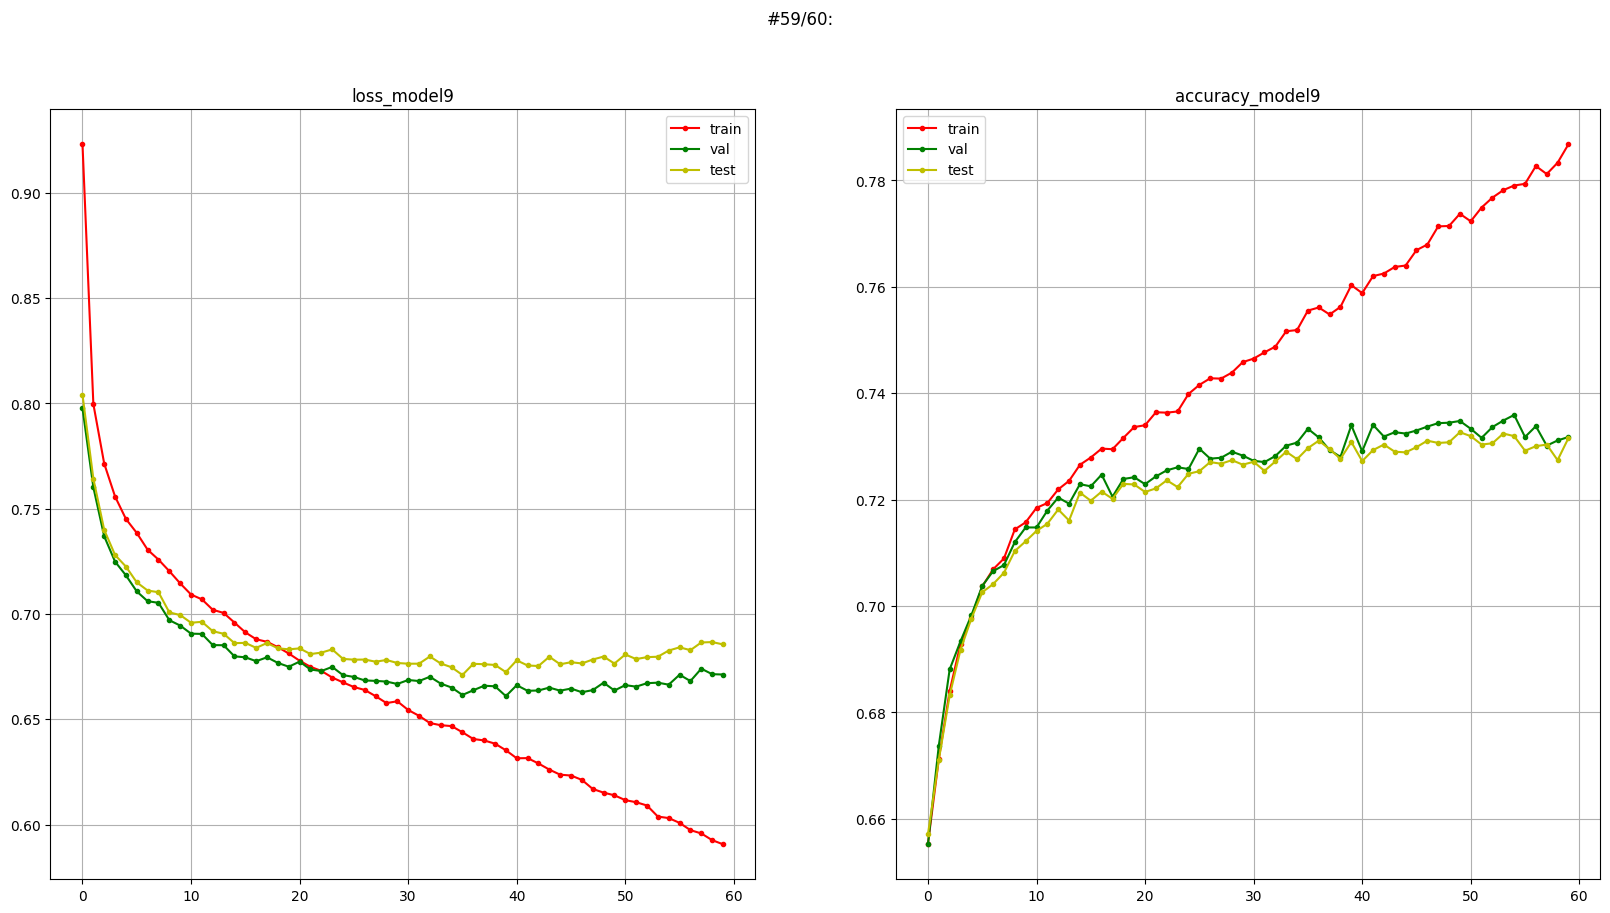

100%|███████████████████████████████████████████| 60/60 [18:02<00:00, 18.04s/it]


0:	learn: 0.6486527	test: 0.6512166	best: 0.6512166 (0)	total: 37.9ms	remaining: 1m 15s
10:	learn: 0.6818504	test: 0.6703986	best: 0.6703986 (10)	total: 411ms	remaining: 1m 14s
20:	learn: 0.6928230	test: 0.6785341	best: 0.6791312 (19)	total: 787ms	remaining: 1m 14s
30:	learn: 0.7022468	test: 0.6848037	best: 0.6848037 (30)	total: 1.18s	remaining: 1m 14s
40:	learn: 0.7106815	test: 0.6921182	best: 0.6921182 (40)	total: 1.56s	remaining: 1m 14s
50:	learn: 0.7180899	test: 0.6965965	best: 0.6965965 (50)	total: 1.93s	remaining: 1m 13s
60:	learn: 0.7238374	test: 0.7012987	best: 0.7012987 (60)	total: 2.29s	remaining: 1m 12s
70:	learn: 0.7283347	test: 0.7059263	best: 0.7059263 (70)	total: 2.63s	remaining: 1m 11s
80:	learn: 0.7329813	test: 0.7080908	best: 0.7080908 (79)	total: 2.96s	remaining: 1m 10s
90:	learn: 0.7373666	test: 0.7093596	best: 0.7103299 (89)	total: 3.31s	remaining: 1m 9s
100:	learn: 0.7416772	test: 0.7113748	best: 0.7114495 (98)	total: 3.66s	remaining: 1m 8s
110:	learn: 0.7455027	t

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7577256	test: 0.7569040	best: 0.7569040 (0)	total: 39.7ms	remaining: 1m 19s
10:	learn: 0.8053669	test: 0.8007912	best: 0.8007912 (10)	total: 407ms	remaining: 1m 13s
20:	learn: 0.8208181	test: 0.8140767	best: 0.8140767 (20)	total: 786ms	remaining: 1m 14s
30:	learn: 0.8336008	test: 0.8269145	best: 0.8269145 (30)	total: 1.15s	remaining: 1m 13s
40:	learn: 0.8460849	test: 0.8353486	best: 0.8353486 (40)	total: 1.53s	remaining: 1m 12s
50:	learn: 0.8554154	test: 0.8433348	best: 0.8433348 (50)	total: 1.91s	remaining: 1m 12s
60:	learn: 0.8650071	test: 0.8499030	best: 0.8499030 (60)	total: 2.27s	remaining: 1m 12s
70:	learn: 0.8720049	test: 0.8563218	best: 0.8563218 (70)	total: 2.62s	remaining: 1m 11s
80:	learn: 0.8788721	test: 0.8610987	best: 0.8610987 (80)	total: 2.98s	remaining: 1m 10s
90:	learn: 0.8847130	test: 0.8654277	best: 0.8655023 (88)	total: 3.35s	remaining: 1m 10s
100:	learn: 0.8896768	test: 0.8697567	best: 0.8697567 (100)	total: 3.7s	remaining: 1m 9s
110:	learn: 0.8942487	

 20%|█████████                                    | 1/5 [01:14<04:58, 74.63s/it]

0:	learn: 0.7417146	test: 0.7450366	best: 0.7450366 (0)	total: 38.4ms	remaining: 1m 16s
10:	learn: 0.7893931	test: 0.7878788	best: 0.7878788 (10)	total: 412ms	remaining: 1m 14s
20:	learn: 0.8043405	test: 0.8021346	best: 0.8021346 (20)	total: 794ms	remaining: 1m 14s
30:	learn: 0.8176271	test: 0.8127332	best: 0.8127332 (30)	total: 1.17s	remaining: 1m 14s
40:	learn: 0.8282451	test: 0.8222869	best: 0.8222869 (40)	total: 1.53s	remaining: 1m 13s
50:	learn: 0.8376502	test: 0.8300493	best: 0.8300493 (50)	total: 1.9s	remaining: 1m 12s
60:	learn: 0.8453012	test: 0.8351246	best: 0.8351246 (60)	total: 2.25s	remaining: 1m 11s
70:	learn: 0.8530268	test: 0.8402000	best: 0.8402000 (70)	total: 2.61s	remaining: 1m 11s
80:	learn: 0.8599127	test: 0.8454993	best: 0.8454993 (80)	total: 2.97s	remaining: 1m 10s
90:	learn: 0.8660148	test: 0.8495298	best: 0.8495298 (90)	total: 3.33s	remaining: 1m 9s
100:	learn: 0.8711279	test: 0.8537841	best: 0.8537841 (100)	total: 3.67s	remaining: 1m 8s
110:	learn: 0.8766328	t

 40%|██████████████████                           | 2/5 [02:29<03:44, 74.97s/it]

0:	learn: 0.7414720	test: 0.7446634	best: 0.7446634 (0)	total: 39.3ms	remaining: 1m 18s
10:	learn: 0.7846533	test: 0.7833259	best: 0.7833259 (10)	total: 415ms	remaining: 1m 14s
20:	learn: 0.8020079	test: 0.8001194	best: 0.8001194 (20)	total: 806ms	remaining: 1m 15s
30:	learn: 0.8146413	test: 0.8076579	best: 0.8085535 (28)	total: 1.18s	remaining: 1m 14s
40:	learn: 0.8237665	test: 0.8156441	best: 0.8156441 (40)	total: 1.55s	remaining: 1m 13s
50:	learn: 0.8319586	test: 0.8225108	best: 0.8225108 (50)	total: 1.91s	remaining: 1m 13s
60:	learn: 0.8405427	test: 0.8292282	best: 0.8292282 (60)	total: 2.28s	remaining: 1m 12s
70:	learn: 0.8489587	test: 0.8360203	best: 0.8360203 (70)	total: 2.64s	remaining: 1m 11s
80:	learn: 0.8552848	test: 0.8413196	best: 0.8413196 (80)	total: 3s	remaining: 1m 11s
90:	learn: 0.8616855	test: 0.8456486	best: 0.8456486 (90)	total: 3.35s	remaining: 1m 10s
100:	learn: 0.8673024	test: 0.8496044	best: 0.8496044 (100)	total: 3.71s	remaining: 1m 9s
110:	learn: 0.8730499	te

 60%|███████████████████████████                  | 3/5 [03:45<02:30, 75.18s/it]

0:	learn: 0.7419758	test: 0.7479475	best: 0.7479475 (0)	total: 37.6ms	remaining: 1m 15s
10:	learn: 0.7912779	test: 0.7919839	best: 0.7919839 (10)	total: 416ms	remaining: 1m 15s
20:	learn: 0.8073263	test: 0.8067622	best: 0.8067622 (20)	total: 798ms	remaining: 1m 15s
30:	learn: 0.8202583	test: 0.8131064	best: 0.8142260 (29)	total: 1.18s	remaining: 1m 15s
40:	learn: 0.8303911	test: 0.8220630	best: 0.8220630 (40)	total: 1.55s	remaining: 1m 14s
50:	learn: 0.8402814	test: 0.8284072	best: 0.8284072 (50)	total: 1.91s	remaining: 1m 13s
60:	learn: 0.8483616	test: 0.8360203	best: 0.8360203 (60)	total: 2.26s	remaining: 1m 11s
70:	learn: 0.8550049	test: 0.8413942	best: 0.8413942 (70)	total: 2.62s	remaining: 1m 11s
80:	learn: 0.8619280	test: 0.8470667	best: 0.8470667 (80)	total: 2.97s	remaining: 1m 10s
90:	learn: 0.8675636	test: 0.8518436	best: 0.8518436 (90)	total: 3.32s	remaining: 1m 9s
100:	learn: 0.8729193	test: 0.8559486	best: 0.8563218 (99)	total: 3.68s	remaining: 1m 9s
110:	learn: 0.8775845	t

 80%|████████████████████████████████████         | 4/5 [04:59<01:15, 75.00s/it]

0:	learn: 0.7372173	test: 0.7378713	best: 0.7378713 (0)	total: 38.9ms	remaining: 1m 17s
10:	learn: 0.7864820	test: 0.7841469	best: 0.7841469 (10)	total: 410ms	remaining: 1m 14s
20:	learn: 0.8031649	test: 0.8007912	best: 0.8007912 (20)	total: 786ms	remaining: 1m 14s
30:	learn: 0.8169366	test: 0.8122854	best: 0.8122854 (30)	total: 1.17s	remaining: 1m 14s
40:	learn: 0.8295887	test: 0.8223615	best: 0.8223615 (40)	total: 1.53s	remaining: 1m 13s
50:	learn: 0.8383034	test: 0.8296761	best: 0.8296761 (50)	total: 1.91s	remaining: 1m 12s
60:	learn: 0.8467381	test: 0.8352739	best: 0.8352739 (60)	total: 2.25s	remaining: 1m 11s
70:	learn: 0.8550795	test: 0.8412450	best: 0.8412450 (70)	total: 2.6s	remaining: 1m 10s
80:	learn: 0.8612376	test: 0.8456486	best: 0.8456486 (79)	total: 2.95s	remaining: 1m 9s
90:	learn: 0.8670411	test: 0.8490073	best: 0.8492312 (87)	total: 3.3s	remaining: 1m 9s
100:	learn: 0.8722475	test: 0.8526646	best: 0.8526646 (100)	total: 3.65s	remaining: 1m 8s
110:	learn: 0.8773233	tes

100%|█████████████████████████████████████████████| 5/5 [06:14<00:00, 74.96s/it]


0:	learn: 0.7532097	test: 0.7581729	best: 0.7581729 (0)	total: 38.1ms	remaining: 1m 16s
10:	learn: 0.7970814	test: 0.7941484	best: 0.7941484 (10)	total: 404ms	remaining: 1m 12s
20:	learn: 0.8130178	test: 0.8089267	best: 0.8089267 (20)	total: 778ms	remaining: 1m 13s
30:	learn: 0.8262111	test: 0.8211673	best: 0.8211673 (30)	total: 1.15s	remaining: 1m 13s
40:	learn: 0.8371837	test: 0.8287804	best: 0.8287804 (40)	total: 1.51s	remaining: 1m 12s
50:	learn: 0.8460476	test: 0.8381102	best: 0.8381102 (50)	total: 1.88s	remaining: 1m 11s
60:	learn: 0.8541091	test: 0.8448276	best: 0.8448276 (60)	total: 2.24s	remaining: 1m 11s
70:	learn: 0.8614429	test: 0.8510972	best: 0.8512465 (69)	total: 2.59s	remaining: 1m 10s
80:	learn: 0.8684780	test: 0.8563218	best: 0.8563218 (80)	total: 2.95s	remaining: 1m 9s
90:	learn: 0.8748414	test: 0.8587103	best: 0.8591581 (88)	total: 3.3s	remaining: 1m 9s
100:	learn: 0.8805330	test: 0.8622929	best: 0.8622929 (100)	total: 3.65s	remaining: 1m 8s
110:	learn: 0.8854034	te

In [72]:
dataset_folder = 'jannis'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, Transformer, ft_transformer_params, optimizer_params, data_model, train_params, metric)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=5, ensemble_size=3)

In [73]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7318922792141876
distill_0 : 0.7210843733205947 ---------> 0.7244879679942676
model_1_metric : 0.7321908401504748
distill_1 : 0.7210843733205947 ---------> 0.7284289723532573
model_2_metric : 0.7317728548396728
distill_2 : 0.7210843733205947 ---------> 0.7271750164208515
model_3_metric : 0.734221054517227
distill_3 : 0.7210843733205947 ---------> 0.7241894070579805
model_4_metric : 0.730100913596465
distill_4 : 0.7210843733205947 ---------> 0.7242491192452379
averaged ensembles accuracy :  0.7279114667303596


In [74]:
# Higgs Parameters
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 70,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

ft_transformer_params = {
    'd_numerical' : 28,
    'categories' : None,
    'token_bias' : True,
    'activation' : 'reglu',
    'attention_dropout' : 0.2285776112227358,
    'd_ffn_factor' : 2.44721762662163,
    'd_token' : 264,
    'ffn_dropout' : 0.3224216086083693,
    'initialization' : 'kaiming',
    'n_heads' : 8,
    'n_layers' : 2,
    'prenormalization' : True,
    'd_out' : 2,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 2.520396383745548e-05,
    'weight_decay' : 1.871343748594096e-05
}

catboost_params = {
    'bagging_temperature' : 0.2762051354652655,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 5.6958564294846,
    'leaf_estimation_iterations' : 8,
    'learning_rate' : 0.04558033669158746,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

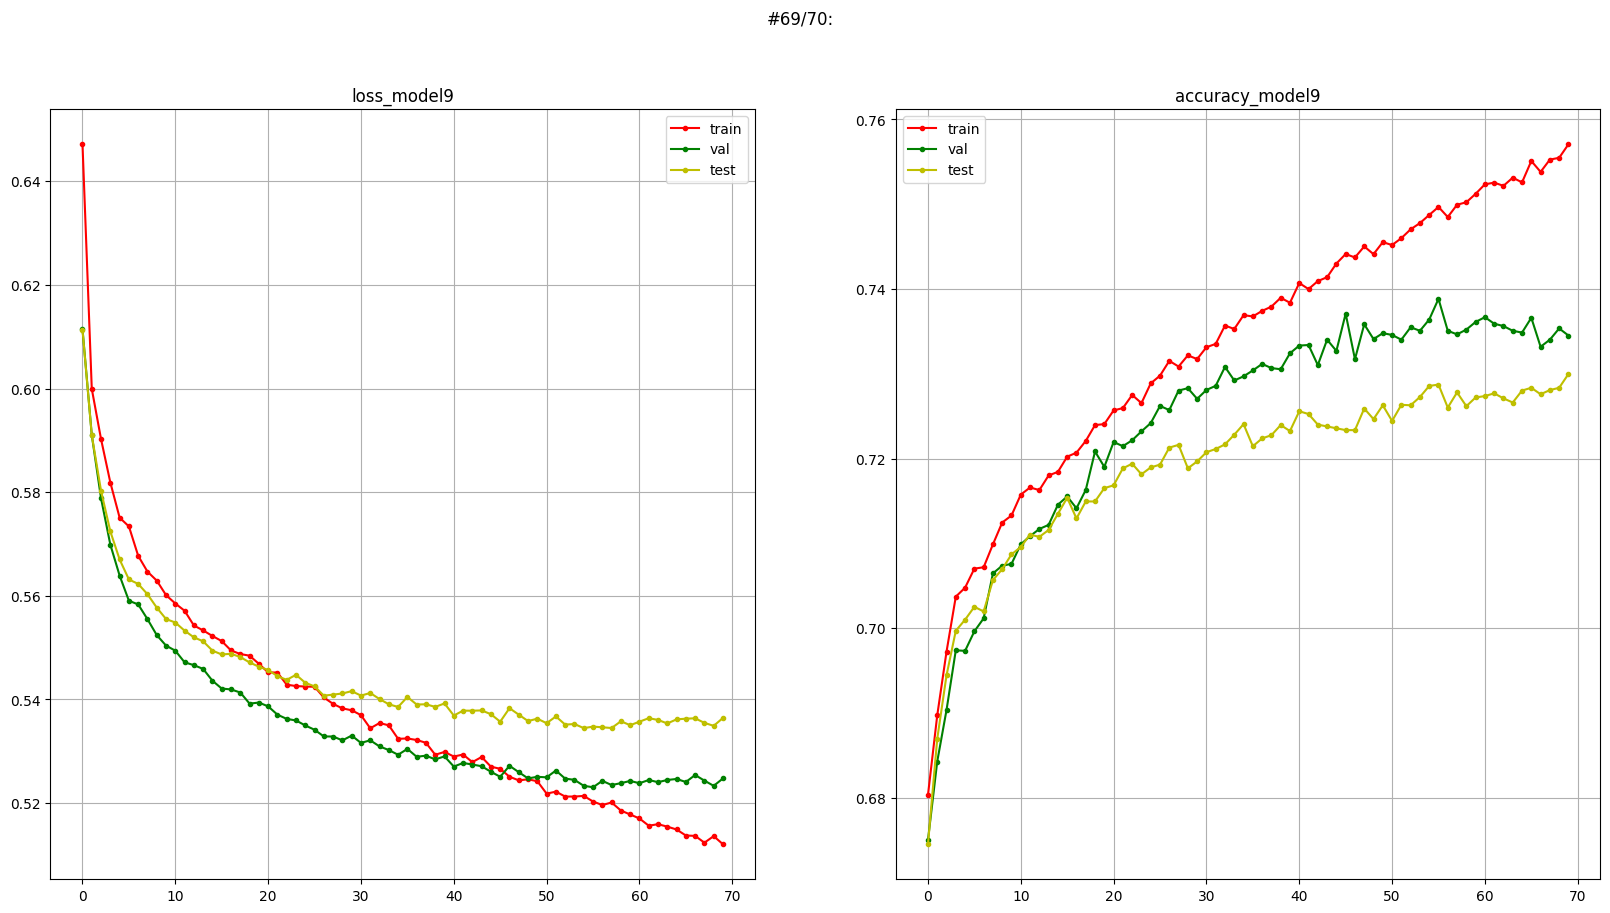

100%|███████████████████████████████████████████| 70/70 [06:58<00:00,  5.97s/it]


0:	learn: 0.6746399	test: 0.6695563	best: 0.6695563 (0)	total: 14.7ms	remaining: 29.3s
10:	learn: 0.6896832	test: 0.6826237	best: 0.6826237 (10)	total: 106ms	remaining: 19.2s
20:	learn: 0.7000892	test: 0.6944161	best: 0.6944161 (20)	total: 190ms	remaining: 17.9s
30:	learn: 0.7083121	test: 0.6998980	best: 0.6998980 (30)	total: 276ms	remaining: 17.5s
40:	learn: 0.7131884	test: 0.7018103	best: 0.7018103 (39)	total: 362ms	remaining: 17.3s
50:	learn: 0.7177779	test: 0.7056986	best: 0.7057624 (49)	total: 446ms	remaining: 17s
60:	learn: 0.7231642	test: 0.7083758	best: 0.7083758 (60)	total: 531ms	remaining: 16.9s
70:	learn: 0.7276900	test: 0.7113717	best: 0.7113717 (70)	total: 617ms	remaining: 16.8s
80:	learn: 0.7309090	test: 0.7130928	best: 0.7134115 (79)	total: 702ms	remaining: 16.6s
90:	learn: 0.7348770	test: 0.7135390	best: 0.7135390 (90)	total: 787ms	remaining: 16.5s
100:	learn: 0.7371717	test: 0.7132203	best: 0.7141764 (95)	total: 871ms	remaining: 16.4s
110:	learn: 0.7404545	test: 0.7159

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.7769952	test: 0.7700153	best: 0.7700153 (0)	total: 9.98ms	remaining: 20s
10:	learn: 0.8144760	test: 0.8069862	best: 0.8069862 (10)	total: 93ms	remaining: 16.8s
20:	learn: 0.8315113	test: 0.8240694	best: 0.8240694 (20)	total: 178ms	remaining: 16.7s
30:	learn: 0.8444352	test: 0.8361168	best: 0.8361168 (30)	total: 263ms	remaining: 16.7s
40:	learn: 0.8564189	test: 0.8455507	best: 0.8455507 (40)	total: 350ms	remaining: 16.7s
50:	learn: 0.8647852	test: 0.8554309	best: 0.8555584 (48)	total: 436ms	remaining: 16.7s
60:	learn: 0.8724503	test: 0.8644187	best: 0.8644187 (60)	total: 524ms	remaining: 16.6s
70:	learn: 0.8785059	test: 0.8695818	best: 0.8695818 (69)	total: 611ms	remaining: 16.6s
80:	learn: 0.8850236	test: 0.8748725	best: 0.8748725 (80)	total: 697ms	remaining: 16.5s
90:	learn: 0.8902983	test: 0.8802269	best: 0.8802269 (90)	total: 782ms	remaining: 16.4s
100:	learn: 0.8937723	test: 0.8832866	best: 0.8832866 (100)	total: 868ms	remaining: 16.3s
110:	learn: 0.8979156	test: 0.8874

 20%|█████████                                    | 1/5 [00:16<01:07, 16.88s/it]

0:	learn: 0.7784453	test: 0.7748598	best: 0.7748598 (0)	total: 8.96ms	remaining: 17.9s
10:	learn: 0.8104921	test: 0.8081973	best: 0.8081973 (10)	total: 90.3ms	remaining: 16.3s
20:	learn: 0.8288023	test: 0.8266191	best: 0.8266191 (20)	total: 172ms	remaining: 16.2s
30:	learn: 0.8421405	test: 0.8395589	best: 0.8395589 (30)	total: 255ms	remaining: 16.2s
40:	learn: 0.8553672	test: 0.8489291	best: 0.8489291 (40)	total: 338ms	remaining: 16.2s
50:	learn: 0.8662035	test: 0.8590643	best: 0.8590643 (50)	total: 421ms	remaining: 16.1s
60:	learn: 0.8739323	test: 0.8649924	best: 0.8649924 (60)	total: 506ms	remaining: 16.1s
70:	learn: 0.8808006	test: 0.8716216	best: 0.8716216 (70)	total: 590ms	remaining: 16s
80:	learn: 0.8869199	test: 0.8771035	best: 0.8771035 (80)	total: 674ms	remaining: 16s
90:	learn: 0.8920194	test: 0.8803544	best: 0.8803544 (90)	total: 759ms	remaining: 15.9s
100:	learn: 0.8961149	test: 0.8832228	best: 0.8834141 (99)	total: 842ms	remaining: 15.8s
110:	learn: 0.9004335	test: 0.88793

 40%|██████████████████                           | 2/5 [00:34<00:51, 17.16s/it]

0:	learn: 0.7764055	test: 0.7699516	best: 0.7699516 (0)	total: 9.63ms	remaining: 19.3s
10:	learn: 0.8085479	test: 0.8056476	best: 0.8056476 (10)	total: 93.5ms	remaining: 16.9s
20:	learn: 0.8246430	test: 0.8213921	best: 0.8213921 (20)	total: 176ms	remaining: 16.6s
30:	learn: 0.8405469	test: 0.8364992	best: 0.8364992 (30)	total: 259ms	remaining: 16.4s
40:	learn: 0.8517816	test: 0.8488016	best: 0.8488016 (40)	total: 343ms	remaining: 16.4s
50:	learn: 0.8605463	test: 0.8556221	best: 0.8556221 (50)	total: 428ms	remaining: 16.4s
60:	learn: 0.8681158	test: 0.8637175	best: 0.8637175 (60)	total: 513ms	remaining: 16.3s
70:	learn: 0.8754621	test: 0.8692631	best: 0.8693906 (69)	total: 597ms	remaining: 16.2s
80:	learn: 0.8821711	test: 0.8747450	best: 0.8747450 (80)	total: 683ms	remaining: 16.2s
90:	learn: 0.8872865	test: 0.8798445	best: 0.8798445 (90)	total: 768ms	remaining: 16.1s
100:	learn: 0.8923381	test: 0.8833503	best: 0.8833503 (100)	total: 852ms	remaining: 16s
110:	learn: 0.8964973	test: 0.88

 60%|███████████████████████████                  | 3/5 [00:51<00:34, 17.35s/it]

0:	learn: 0.7694575	test: 0.7624936	best: 0.7624936 (0)	total: 9.34ms	remaining: 18.7s
10:	learn: 0.8053927	test: 0.8020143	best: 0.8020143 (10)	total: 93ms	remaining: 16.8s
20:	learn: 0.8239578	test: 0.8178225	best: 0.8178225 (20)	total: 177ms	remaining: 16.7s
30:	learn: 0.8386665	test: 0.8313998	best: 0.8313998 (30)	total: 262ms	remaining: 16.7s
40:	learn: 0.8503952	test: 0.8437022	best: 0.8437022 (40)	total: 348ms	remaining: 16.6s
50:	learn: 0.8597814	test: 0.8528174	best: 0.8530087 (49)	total: 432ms	remaining: 16.5s
60:	learn: 0.8680998	test: 0.8611040	best: 0.8611040 (60)	total: 518ms	remaining: 16.5s
70:	learn: 0.8749203	test: 0.8665859	best: 0.8665859 (70)	total: 603ms	remaining: 16.4s
80:	learn: 0.8810396	test: 0.8716216	best: 0.8717491 (79)	total: 690ms	remaining: 16.3s
90:	learn: 0.8854539	test: 0.8753187	best: 0.8753187 (90)	total: 778ms	remaining: 16.3s
100:	learn: 0.8895971	test: 0.8786334	best: 0.8786334 (100)	total: 865ms	remaining: 16.3s
110:	learn: 0.8935014	test: 0.88

 80%|████████████████████████████████████         | 4/5 [01:09<00:17, 17.46s/it]

0:	learn: 0.7785250	test: 0.7737761	best: 0.7737761 (0)	total: 8.89ms	remaining: 17.8s
10:	learn: 0.8164999	test: 0.8129143	best: 0.8129143 (10)	total: 84.3ms	remaining: 15.2s
20:	learn: 0.8335671	test: 0.8305711	best: 0.8305711 (20)	total: 160ms	remaining: 15.1s
30:	learn: 0.8469371	test: 0.8451045	best: 0.8451045 (30)	total: 237ms	remaining: 15s
40:	learn: 0.8594786	test: 0.8553034	best: 0.8553034 (40)	total: 314ms	remaining: 15s
50:	learn: 0.8691197	test: 0.8642912	best: 0.8642912 (50)	total: 392ms	remaining: 15s
60:	learn: 0.8781712	test: 0.8702830	best: 0.8702830 (60)	total: 470ms	remaining: 14.9s
70:	learn: 0.8849917	test: 0.8766573	best: 0.8766573 (70)	total: 546ms	remaining: 14.8s
80:	learn: 0.8906489	test: 0.8805456	best: 0.8805456 (79)	total: 624ms	remaining: 14.8s
90:	learn: 0.8958440	test: 0.8855813	best: 0.8855813 (89)	total: 702ms	remaining: 14.7s
100:	learn: 0.9003219	test: 0.8904258	best: 0.8907445 (98)	total: 779ms	remaining: 14.6s
110:	learn: 0.9045289	test: 0.8928480

100%|█████████████████████████████████████████████| 5/5 [01:25<00:00, 17.14s/it]


0:	learn: 0.7797680	test: 0.7730750	best: 0.7730750 (0)	total: 9.74ms	remaining: 19.5s
10:	learn: 0.8122132	test: 0.8061576	best: 0.8061576 (10)	total: 93ms	remaining: 16.8s
20:	learn: 0.8305233	test: 0.8253442	best: 0.8253442 (20)	total: 176ms	remaining: 16.6s
30:	learn: 0.8452798	test: 0.8387940	best: 0.8387940 (30)	total: 259ms	remaining: 16.4s
40:	learn: 0.8569767	test: 0.8501402	best: 0.8501402 (40)	total: 344ms	remaining: 16.4s
50:	learn: 0.8657891	test: 0.8589368	best: 0.8589368 (50)	total: 427ms	remaining: 16.3s
60:	learn: 0.8746972	test: 0.8657573	best: 0.8657573 (60)	total: 511ms	remaining: 16.2s
70:	learn: 0.8810715	test: 0.8721316	best: 0.8721316 (70)	total: 595ms	remaining: 16.2s
80:	learn: 0.8865694	test: 0.8753187	best: 0.8755099 (79)	total: 678ms	remaining: 16.1s
90:	learn: 0.8915094	test: 0.8811193	best: 0.8811193 (90)	total: 763ms	remaining: 16s
100:	learn: 0.8957483	test: 0.8844977	best: 0.8844977 (100)	total: 846ms	remaining: 15.9s
110:	learn: 0.8999076	test: 0.8876

In [75]:
dataset_folder = 'higgs_small'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile')
results_models_learning = LearnNModels(9, Transformer, ft_transformer_params, optimizer_params, data_model, train_params, metric)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=5, ensemble_size=3)

In [76]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.7281998980112188
distill_0 : 0.7250892401835798 ---------> 0.7258031616522183
model_1_metric : 0.7306476287608363
distill_1 : 0.7250892401835798 ---------> 0.7241203467618562
model_2_metric : 0.7308516063233045
distill_2 : 0.7250892401835798 ---------> 0.7272819989801121
model_3_metric : 0.7271800101988781
distill_3 : 0.7250892401835798 ---------> 0.7250892401835798
model_4_metric : 0.7288628250892402
distill_4 : 0.7250892401835798 ---------> 0.7263640999490056
averaged ensembles accuracy :  0.7251912289648138


In [13]:
train_params = {
    'batch_size' : 256,
    'eval_batch_size' : 2048,
    'num_epochs' : 150,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

ft_transformer_params = {
    'd_numerical' : 8,
    'categories' : None,
    'token_bias' : True,
    'activation' : 'reglu',
    'attention_dropout' : 0.4518858598707761,
    'd_ffn_factor' : 2.342425545888827,
    'd_token' : 272,
    'ffn_dropout' : 0.1462394754853018,
    'initialization' : 'kaiming',
    'n_heads' : 8,
    'n_layers' : 3,
    'prenormalization' : False,
    'd_out' : 1,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 9.230462560646988e-05,
    'weight_decay' : 2.242573649081314e-06
}

catboost_params = {
    'bagging_temperature' : 0.004350736313860622,
    'depth' : 9,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 8.157639995907031,
    'leaf_estimation_iterations' : 4,
    'learning_rate' : 0.1021076879315874,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

In [20]:
dataset_folder = 'california_housing'
metric = mean_squared_error

#data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
#results_models_learning = LearnNModels(15, Transformer, ft_transformer_params, optimizer_params, data_model, train_params, metric, regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, ensemble_size=5, regression=True)

0:	learn: 0.9361596	test: 0.9365706	best: 0.9365706 (0)	total: 132ms	remaining: 4m 22s
10:	learn: 0.5903575	test: 0.6043515	best: 0.6043515 (10)	total: 833ms	remaining: 2m 30s
20:	learn: 0.4907550	test: 0.5116647	best: 0.5116647 (20)	total: 1.47s	remaining: 2m 18s
30:	learn: 0.4548279	test: 0.4788678	best: 0.4788678 (30)	total: 2.11s	remaining: 2m 14s
40:	learn: 0.4322337	test: 0.4612566	best: 0.4612566 (40)	total: 2.75s	remaining: 2m 11s
50:	learn: 0.4180322	test: 0.4510834	best: 0.4510834 (50)	total: 3.39s	remaining: 2m 9s
60:	learn: 0.4077928	test: 0.4452423	best: 0.4452423 (60)	total: 3.98s	remaining: 2m 6s
70:	learn: 0.3968504	test: 0.4364781	best: 0.4364781 (70)	total: 4.62s	remaining: 2m 5s
80:	learn: 0.3911905	test: 0.4334863	best: 0.4334863 (80)	total: 5.05s	remaining: 1m 59s
90:	learn: 0.3870045	test: 0.4308548	best: 0.4308548 (90)	total: 5.48s	remaining: 1m 54s
100:	learn: 0.3827532	test: 0.4287226	best: 0.4287226 (100)	total: 5.95s	remaining: 1m 51s
110:	learn: 0.3789732	te

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.9117998	test: 0.9016171	best: 0.9016171 (0)	total: 66.8ms	remaining: 2m 13s
10:	learn: 0.5041747	test: 0.4965007	best: 0.4965007 (10)	total: 717ms	remaining: 2m 9s
20:	learn: 0.3736133	test: 0.3644985	best: 0.3644985 (20)	total: 1.37s	remaining: 2m 8s
30:	learn: 0.3221265	test: 0.3148205	best: 0.3148205 (30)	total: 2.02s	remaining: 2m 8s
40:	learn: 0.2959108	test: 0.2907863	best: 0.2907863 (40)	total: 2.61s	remaining: 2m 4s
50:	learn: 0.2788521	test: 0.2743480	best: 0.2743480 (50)	total: 3.26s	remaining: 2m 4s
60:	learn: 0.2594390	test: 0.2586685	best: 0.2586685 (60)	total: 3.92s	remaining: 2m 4s
70:	learn: 0.2461152	test: 0.2483307	best: 0.2483307 (70)	total: 4.57s	remaining: 2m 4s
80:	learn: 0.2345447	test: 0.2385968	best: 0.2385968 (80)	total: 5.23s	remaining: 2m 3s
90:	learn: 0.2243223	test: 0.2304122	best: 0.2304122 (90)	total: 5.89s	remaining: 2m 3s
100:	learn: 0.2180301	test: 0.2256898	best: 0.2256898 (100)	total: 6.43s	remaining: 2m
110:	learn: 0.2145092	test: 0.223

 20%|█████████                                    | 1/5 [00:37<02:29, 37.42s/it]

0:	learn: 0.9096391	test: 0.8978587	best: 0.8978587 (0)	total: 67.7ms	remaining: 2m 15s
10:	learn: 0.5092084	test: 0.5032726	best: 0.5032726 (10)	total: 733ms	remaining: 2m 12s
20:	learn: 0.3689305	test: 0.3648099	best: 0.3648099 (20)	total: 1.4s	remaining: 2m 11s
30:	learn: 0.3132171	test: 0.3125417	best: 0.3125417 (30)	total: 2.06s	remaining: 2m 10s
40:	learn: 0.2852141	test: 0.2883146	best: 0.2883146 (40)	total: 2.73s	remaining: 2m 10s
50:	learn: 0.2699537	test: 0.2747949	best: 0.2747949 (50)	total: 3.28s	remaining: 2m 5s
60:	learn: 0.2536537	test: 0.2603440	best: 0.2603440 (60)	total: 3.89s	remaining: 2m 3s
70:	learn: 0.2353836	test: 0.2448841	best: 0.2448841 (70)	total: 4.56s	remaining: 2m 3s
80:	learn: 0.2258370	test: 0.2366033	best: 0.2366033 (80)	total: 5.22s	remaining: 2m 3s
90:	learn: 0.2180803	test: 0.2296016	best: 0.2296016 (90)	total: 5.77s	remaining: 2m 1s
100:	learn: 0.2115265	test: 0.2239459	best: 0.2239459 (100)	total: 6.27s	remaining: 1m 57s
110:	learn: 0.2082373	test

 40%|██████████████████                           | 2/5 [01:19<02:00, 40.32s/it]

0:	learn: 0.8883189	test: 0.8775218	best: 0.8775218 (0)	total: 65.6ms	remaining: 2m 11s
10:	learn: 0.4913169	test: 0.4895589	best: 0.4895589 (10)	total: 708ms	remaining: 2m 7s
20:	learn: 0.3453800	test: 0.3452945	best: 0.3452945 (20)	total: 1.35s	remaining: 2m 7s
30:	learn: 0.2899769	test: 0.2934365	best: 0.2934365 (30)	total: 1.99s	remaining: 2m 6s
40:	learn: 0.2611868	test: 0.2678667	best: 0.2678667 (40)	total: 2.63s	remaining: 2m 5s
50:	learn: 0.2467997	test: 0.2554304	best: 0.2554304 (50)	total: 3.22s	remaining: 2m 3s
60:	learn: 0.2355279	test: 0.2450836	best: 0.2450836 (60)	total: 3.64s	remaining: 1m 55s
70:	learn: 0.2196250	test: 0.2316747	best: 0.2316747 (70)	total: 4.29s	remaining: 1m 56s
80:	learn: 0.2056640	test: 0.2200310	best: 0.2200310 (80)	total: 4.94s	remaining: 1m 57s
90:	learn: 0.1961621	test: 0.2127151	best: 0.2127151 (90)	total: 5.47s	remaining: 1m 54s
100:	learn: 0.1878850	test: 0.2050716	best: 0.2050716 (100)	total: 6.12s	remaining: 1m 55s
110:	learn: 0.1794876	tes

 60%|███████████████████████████                  | 3/5 [02:00<01:21, 40.57s/it]

1999:	learn: 0.1076049	test: 0.1517834	best: 0.1517810 (1789)	total: 40.5s	remaining: 0us
bestTest = 0.1517809959
bestIteration = 1789
Shrink model to first 1790 iterations.
0:	learn: 0.9171221	test: 0.9012526	best: 0.9012526 (0)	total: 66.4ms	remaining: 2m 12s
10:	learn: 0.5165545	test: 0.5027849	best: 0.5027849 (10)	total: 720ms	remaining: 2m 10s
20:	learn: 0.3857475	test: 0.3756740	best: 0.3756740 (20)	total: 1.37s	remaining: 2m 8s
30:	learn: 0.3332514	test: 0.3247523	best: 0.3247523 (30)	total: 2.02s	remaining: 2m 8s
40:	learn: 0.3047681	test: 0.2994707	best: 0.2994707 (40)	total: 2.67s	remaining: 2m 7s
50:	learn: 0.2887854	test: 0.2865608	best: 0.2865608 (50)	total: 3.31s	remaining: 2m 6s
60:	learn: 0.2815854	test: 0.2806551	best: 0.2806551 (60)	total: 3.73s	remaining: 1m 58s
70:	learn: 0.2697594	test: 0.2705294	best: 0.2705294 (70)	total: 4.26s	remaining: 1m 55s
80:	learn: 0.2563248	test: 0.2609032	best: 0.2609032 (80)	total: 4.89s	remaining: 1m 55s
90:	learn: 0.2460580	test: 0.2

 80%|████████████████████████████████████         | 4/5 [02:38<00:39, 39.45s/it]

1999:	learn: 0.1580055	test: 0.1974930	best: 0.1974930 (1939)	total: 37.4s	remaining: 0us
bestTest = 0.1974930315
bestIteration = 1939
Shrink model to first 1940 iterations.
0:	learn: 0.9035830	test: 0.8925068	best: 0.8925068 (0)	total: 66.8ms	remaining: 2m 13s
10:	learn: 0.5062363	test: 0.4986855	best: 0.4986855 (10)	total: 720ms	remaining: 2m 10s
20:	learn: 0.3685000	test: 0.3599954	best: 0.3599954 (20)	total: 1.37s	remaining: 2m 8s
30:	learn: 0.3136577	test: 0.3077069	best: 0.3077069 (30)	total: 2.02s	remaining: 2m 8s
40:	learn: 0.2865247	test: 0.2835942	best: 0.2835942 (40)	total: 2.67s	remaining: 2m 7s
50:	learn: 0.2682646	test: 0.2693096	best: 0.2693096 (50)	total: 3.33s	remaining: 2m 7s
60:	learn: 0.2532205	test: 0.2564163	best: 0.2564163 (60)	total: 3.92s	remaining: 2m 4s
70:	learn: 0.2391223	test: 0.2437682	best: 0.2437682 (70)	total: 4.57s	remaining: 2m 4s
80:	learn: 0.2266427	test: 0.2336818	best: 0.2336818 (80)	total: 5.23s	remaining: 2m 3s
90:	learn: 0.2197378	test: 0.2284

100%|█████████████████████████████████████████████| 5/5 [02:59<00:00, 35.91s/it]

1380:	learn: 0.1820854	test: 0.2020804	best: 0.2020722 (442)	total: 20.8s	remaining: 9.31s
1390:	learn: 0.1820854	test: 0.2020804	best: 0.2020722 (442)	total: 20.9s	remaining: 9.13s
bestTest = 0.2020722266
bestIteration = 442
Shrink model to first 443 iterations.


0:	learn: 0.9028570	test: 0.8906429	best: 0.8906429 (0)	total: 66.1ms	remaining: 2m 12s
10:	learn: 0.5045119	test: 0.4981477	best: 0.4981477 (10)	total: 719ms	remaining: 2m 9s
20:	learn: 0.3617703	test: 0.3546739	best: 0.3546739 (20)	total: 1.37s	remaining: 2m 9s
30:	learn: 0.3097905	test: 0.3019064	best: 0.3019064 (30)	total: 2.02s	remaining: 2m 8s
40:	learn: 0.2814748	test: 0.2760284	best: 0.2760284 (40)	total: 2.67s	remaining: 2m 7s
50:	learn: 0.2619524	test: 0.2600643	best: 0.2600643 (50)	total: 3.32s	remaining: 2m 6s
60:	learn: 0.2501246	test: 0.2500094	best: 0.2500094 (60)	total: 3.81s	remaining: 2m 1s
70:	learn: 0.2373154	test: 0.2394376	best: 0.2394376 (70)	total: 4.35s	remaining: 1m 58s
80:	learn: 0.2220389	test: 0.2268093	best: 0.2268093 (80)	total: 5.01s	remaining: 1m 58s
90:	learn: 0.2150381	test: 0.2208955	best: 0.2208955 (90)	total: 5.49s	remaining: 1m 55s
100:	learn: 0.2065253	test: 0.2142600	best: 0.2142600 (100)	total: 6.14s	remaining: 1m 55s
110:	learn: 0.2008697	test

In [21]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 0.4652807664431737
distill_0 : 0.4553413563115973 ---------> 0.46709729283065793
model_1_metric : 0.4615431094031918
distill_1 : 0.4553413563115973 ---------> 0.46558676419271144
model_2_metric : 0.46026413179695674
distill_2 : 0.4553413563115973 ---------> 0.4677031904766775
model_3_metric : 0.46624222792113795
distill_3 : 0.4553413563115973 ---------> 0.4631039590926776
model_4_metric : 0.4728529284435549
distill_4 : 0.4553413563115973 ---------> 0.4835180048878504
averaged ensembles accuracy :  0.46645381076905235


In [7]:
train_params = {
    'batch_size' : 1024,
    'eval_batch_size' : 2048,
    'num_epochs' : 180,
    'patience' : 16,
    'criterion' : nn.MSELoss(),
}

ft_transformer_params = {
    'd_numerical' : 90,
    'categories' : None,
    'token_bias' : True,
    'activation' : 'reglu',
    'attention_dropout' : 0.3950042559826507,
    'd_ffn_factor' : 1.333333333333333,
    'd_token' : 384,
    'ffn_dropout' : 0.294021729767271,
    'initialization' : 'kaiming',
    'n_heads' : 8,
    'n_layers' : 1,
    'prenormalization' : True,
    'd_out' : 1,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 6.892111668257778e-05,
    'weight_decay' : 5.05413243507343e-05
}

catboost_params = {
    'bagging_temperature' : 0.8324949854063162,
    'depth' : 10,
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'l2_leaf_reg' : 1.077941041711693,
    'leaf_estimation_iterations' : 2,
    'learning_rate' : 0.04659912850277395,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'RMSE'
}

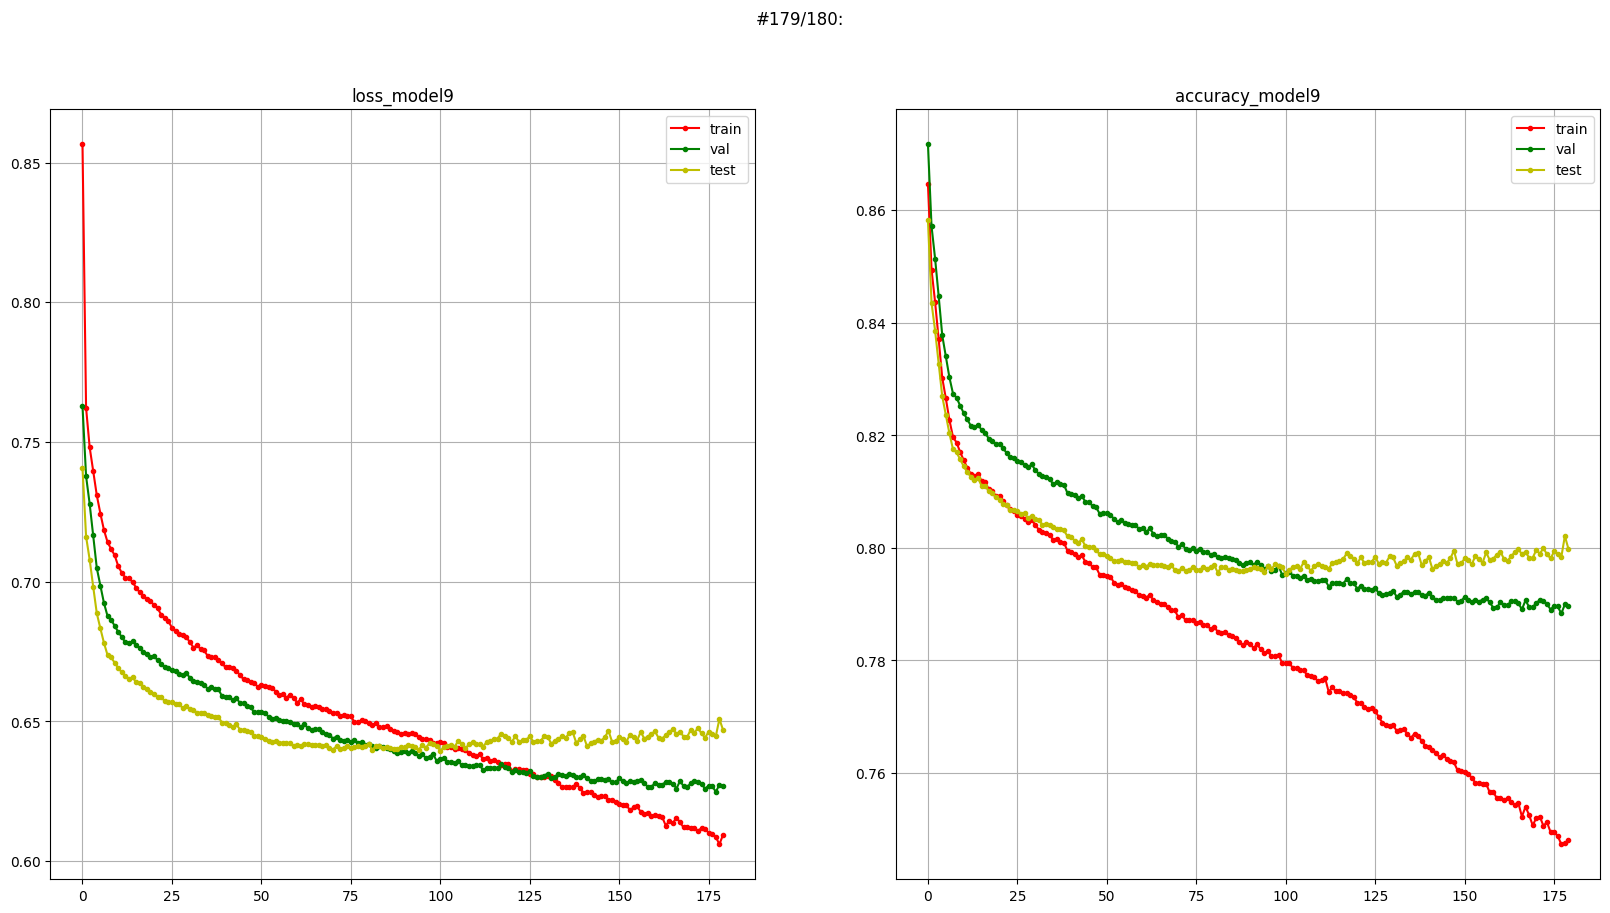

100%|███████████████████████████████████████| 180/180 [1:13:38<00:00, 24.55s/it]


0:	learn: 0.9914147	test: 0.9967809	best: 0.9967809 (0)	total: 59.4ms	remaining: 1m 58s
10:	learn: 0.9324685	test: 0.9388348	best: 0.9388348 (10)	total: 232ms	remaining: 42s
20:	learn: 0.9001344	test: 0.9072233	best: 0.9072233 (20)	total: 410ms	remaining: 38.7s
30:	learn: 0.8800481	test: 0.8877585	best: 0.8877585 (30)	total: 587ms	remaining: 37.3s
40:	learn: 0.8667816	test: 0.8750099	best: 0.8750099 (40)	total: 764ms	remaining: 36.5s
50:	learn: 0.8572563	test: 0.8662189	best: 0.8662189 (50)	total: 945ms	remaining: 36.1s
60:	learn: 0.8499228	test: 0.8598097	best: 0.8598097 (60)	total: 1.12s	remaining: 35.7s
70:	learn: 0.8441134	test: 0.8547046	best: 0.8547046 (70)	total: 1.3s	remaining: 35.5s
80:	learn: 0.8388913	test: 0.8506284	best: 0.8506284 (80)	total: 1.48s	remaining: 35.2s
90:	learn: 0.8344994	test: 0.8473707	best: 0.8473707 (90)	total: 1.67s	remaining: 35s
100:	learn: 0.8307917	test: 0.8446539	best: 0.8446539 (100)	total: 1.85s	remaining: 34.8s
110:	learn: 0.8271697	test: 0.84222

  0%|                                                     | 0/5 [00:00<?, ?it/s]

0:	learn: 0.6005081	test: 0.6013340	best: 0.6013340 (0)	total: 18.1ms	remaining: 36.2s
10:	learn: 0.5021366	test: 0.5024112	best: 0.5024112 (10)	total: 191ms	remaining: 34.5s
20:	learn: 0.4438852	test: 0.4438392	best: 0.4438392 (20)	total: 363ms	remaining: 34.2s
30:	learn: 0.4056377	test: 0.4053731	best: 0.4053731 (30)	total: 540ms	remaining: 34.3s
40:	learn: 0.3795260	test: 0.3791638	best: 0.3791638 (40)	total: 719ms	remaining: 34.3s
50:	learn: 0.3600972	test: 0.3597101	best: 0.3597101 (50)	total: 900ms	remaining: 34.4s
60:	learn: 0.3455451	test: 0.3450450	best: 0.3450450 (60)	total: 1.08s	remaining: 34.3s
70:	learn: 0.3343329	test: 0.3339842	best: 0.3339842 (70)	total: 1.26s	remaining: 34.3s
80:	learn: 0.3249436	test: 0.3247788	best: 0.3247788 (80)	total: 1.44s	remaining: 34.2s
90:	learn: 0.3169458	test: 0.3170591	best: 0.3170591 (90)	total: 1.63s	remaining: 34.1s
100:	learn: 0.3102050	test: 0.3105385	best: 0.3105385 (100)	total: 1.81s	remaining: 34s
110:	learn: 0.3042775	test: 0.304

 20%|█████████                                    | 1/5 [00:38<02:32, 38.20s/it]

0:	learn: 0.5944933	test: 0.5948495	best: 0.5948495 (0)	total: 17.9ms	remaining: 35.7s
10:	learn: 0.4969350	test: 0.4969317	best: 0.4969317 (10)	total: 187ms	remaining: 33.7s
20:	learn: 0.4384732	test: 0.4381811	best: 0.4381811 (20)	total: 361ms	remaining: 34s
30:	learn: 0.4004963	test: 0.4000896	best: 0.4000896 (30)	total: 539ms	remaining: 34.2s
40:	learn: 0.3742871	test: 0.3736485	best: 0.3736485 (40)	total: 716ms	remaining: 34.2s
50:	learn: 0.3550361	test: 0.3543917	best: 0.3543917 (50)	total: 891ms	remaining: 34.1s
60:	learn: 0.3404183	test: 0.3397729	best: 0.3397729 (60)	total: 1.07s	remaining: 34.1s
70:	learn: 0.3289215	test: 0.3283487	best: 0.3283487 (70)	total: 1.25s	remaining: 34.1s
80:	learn: 0.3196316	test: 0.3193090	best: 0.3193090 (80)	total: 1.44s	remaining: 34s
90:	learn: 0.3114848	test: 0.3113528	best: 0.3113528 (90)	total: 1.62s	remaining: 34.1s
100:	learn: 0.3045929	test: 0.3046468	best: 0.3046468 (100)	total: 1.8s	remaining: 33.9s
110:	learn: 0.2984547	test: 0.298704

 40%|██████████████████                           | 2/5 [01:16<01:54, 38.23s/it]

0:	learn: 0.5837604	test: 0.5829165	best: 0.5829165 (0)	total: 17.8ms	remaining: 35.6s
10:	learn: 0.4888868	test: 0.4875754	best: 0.4875754 (10)	total: 185ms	remaining: 33.5s
20:	learn: 0.4319168	test: 0.4302445	best: 0.4302445 (20)	total: 360ms	remaining: 33.9s
30:	learn: 0.3945746	test: 0.3927251	best: 0.3927251 (30)	total: 534ms	remaining: 33.9s
40:	learn: 0.3693697	test: 0.3674276	best: 0.3674276 (40)	total: 713ms	remaining: 34.1s
50:	learn: 0.3506166	test: 0.3485589	best: 0.3485589 (50)	total: 888ms	remaining: 34s
60:	learn: 0.3362737	test: 0.3342087	best: 0.3342087 (60)	total: 1.07s	remaining: 34s
70:	learn: 0.3250529	test: 0.3231282	best: 0.3231282 (70)	total: 1.25s	remaining: 33.9s
80:	learn: 0.3159596	test: 0.3141775	best: 0.3141775 (80)	total: 1.43s	remaining: 33.8s
90:	learn: 0.3080919	test: 0.3065269	best: 0.3065269 (90)	total: 1.61s	remaining: 33.8s
100:	learn: 0.3012236	test: 0.2999627	best: 0.2999627 (100)	total: 1.8s	remaining: 33.8s
110:	learn: 0.2955153	test: 0.294558

 60%|███████████████████████████                  | 3/5 [01:54<01:16, 38.19s/it]

0:	learn: 0.5959019	test: 0.5942463	best: 0.5942463 (0)	total: 17.9ms	remaining: 35.7s
10:	learn: 0.4983121	test: 0.4960713	best: 0.4960713 (10)	total: 187ms	remaining: 33.8s
20:	learn: 0.4402104	test: 0.4376104	best: 0.4376104 (20)	total: 357ms	remaining: 33.7s
30:	learn: 0.4022743	test: 0.3993734	best: 0.3993734 (30)	total: 532ms	remaining: 33.8s
40:	learn: 0.3762174	test: 0.3732041	best: 0.3732041 (40)	total: 713ms	remaining: 34.1s
50:	learn: 0.3573020	test: 0.3542347	best: 0.3542347 (50)	total: 890ms	remaining: 34s
60:	learn: 0.3428283	test: 0.3397524	best: 0.3397524 (60)	total: 1.07s	remaining: 34.1s
70:	learn: 0.3314920	test: 0.3285049	best: 0.3285049 (70)	total: 1.25s	remaining: 34s
80:	learn: 0.3220709	test: 0.3192570	best: 0.3192570 (80)	total: 1.44s	remaining: 34s
90:	learn: 0.3138562	test: 0.3111910	best: 0.3111910 (90)	total: 1.62s	remaining: 34s
100:	learn: 0.3068632	test: 0.3043977	best: 0.3043977 (100)	total: 1.8s	remaining: 33.9s
110:	learn: 0.3010938	test: 0.2989149	be

 80%|████████████████████████████████████         | 4/5 [02:32<00:38, 38.14s/it]

0:	learn: 0.5921409	test: 0.5913594	best: 0.5913594 (0)	total: 18ms	remaining: 36s
10:	learn: 0.4942485	test: 0.4928516	best: 0.4928516 (10)	total: 187ms	remaining: 33.8s
20:	learn: 0.4355948	test: 0.4337289	best: 0.4337289 (20)	total: 361ms	remaining: 34s
30:	learn: 0.3980172	test: 0.3959749	best: 0.3959749 (30)	total: 539ms	remaining: 34.2s
40:	learn: 0.3716527	test: 0.3693978	best: 0.3693978 (40)	total: 716ms	remaining: 34.2s
50:	learn: 0.3526489	test: 0.3503601	best: 0.3503601 (50)	total: 893ms	remaining: 34.1s
60:	learn: 0.3380950	test: 0.3357417	best: 0.3357417 (60)	total: 1.07s	remaining: 34.1s
70:	learn: 0.3268431	test: 0.3246158	best: 0.3246158 (70)	total: 1.26s	remaining: 34.2s
80:	learn: 0.3172803	test: 0.3152821	best: 0.3152821 (80)	total: 1.44s	remaining: 34.1s
90:	learn: 0.3093109	test: 0.3074775	best: 0.3074775 (90)	total: 1.62s	remaining: 34s
100:	learn: 0.3023528	test: 0.3007374	best: 0.3007374 (100)	total: 1.8s	remaining: 33.9s
110:	learn: 0.2962434	test: 0.2949054	be

100%|█████████████████████████████████████████████| 5/5 [03:10<00:00, 38.18s/it]


0:	learn: 0.5891131	test: 0.5889879	best: 0.5889879 (0)	total: 18.2ms	remaining: 36.3s
10:	learn: 0.4919295	test: 0.4912922	best: 0.4912922 (10)	total: 187ms	remaining: 33.8s
20:	learn: 0.4334231	test: 0.4323388	best: 0.4323388 (20)	total: 365ms	remaining: 34.4s
30:	learn: 0.3952913	test: 0.3940297	best: 0.3940297 (30)	total: 542ms	remaining: 34.4s
40:	learn: 0.3689675	test: 0.3675083	best: 0.3675083 (40)	total: 718ms	remaining: 34.3s
50:	learn: 0.3500723	test: 0.3486446	best: 0.3486446 (50)	total: 905ms	remaining: 34.6s
60:	learn: 0.3349561	test: 0.3334985	best: 0.3334985 (60)	total: 1.08s	remaining: 34.4s
70:	learn: 0.3234563	test: 0.3219742	best: 0.3219742 (70)	total: 1.26s	remaining: 34.3s
80:	learn: 0.3138083	test: 0.3124189	best: 0.3124189 (80)	total: 1.45s	remaining: 34.3s
90:	learn: 0.3055967	test: 0.3043573	best: 0.3043573 (90)	total: 1.62s	remaining: 34.1s
100:	learn: 0.2984790	test: 0.2975042	best: 0.2975042 (100)	total: 1.81s	remaining: 34s
110:	learn: 0.2924540	test: 0.291

In [8]:
dataset_folder = 'year'
metric = mean_squared_error

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='quantile', regression=True)
results_models_learning = LearnNModels(9, Transformer, ft_transformer_params, optimizer_params, data_model, train_params, metric, regression=True)
torch.cuda.empty_cache()
gc.collect()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostRegressor, catboost_params, data_cb, metric, N=5, ensemble_size=3, regression=True)

In [9]:
PrintResults(results_models_learning, results_cb_learning, regression=True, std=data_cb['std'])

model_0_metric : 8.840946334870885
distill_0 : 8.886524300635156 ---------> 8.916160870496649
model_1_metric : 8.849931103154901
distill_1 : 8.886524300635156 ---------> 8.91985378298815
model_2_metric : 8.856861516696316
distill_2 : 8.886524300635156 ---------> 8.927027336698286
model_3_metric : 8.857346952901535
distill_3 : 8.886524300635156 ---------> 8.912432792294348
model_4_metric : 8.859889834197697
distill_4 : 8.886524300635156 ---------> 8.930043074452355
averaged ensembles accuracy :  8.91752911099259


In [8]:
train_params = {
    'batch_size' : 512,
    'eval_batch_size' : 2048,
    'num_epochs' : 100,
    'patience' : 16,
    'criterion' : nn.CrossEntropyLoss(),
}

ft_transformer_params = {
    'd_numerical' : 128,
    'categories' : None,
    'token_bias' : True,
    'activation' : 'reglu',
    'attention_dropout' : 0.09787670784308798,
    'd_ffn_factor' : 1.333333333333333,
    'd_token' : 288,
    'ffn_dropout' : 0.2343226573344421,
    'initialization' : 'kaiming',
    'n_heads' : 8,
    'n_layers' : 2,
    'prenormalization' : True,
    'd_out' : 1000,
    'residual_dropout' : 0.0,
    'kv_compression' : None,
    'kv_compression_sharing' : None
}

optimizer_params = {
    'lr' : 4.416158606411414e-05,
    'weight_decay' : 4.671445569232747e-06
}

catboost_params = {
    'early_stopping_rounds' : 50,
    'iterations' : 2000,
    'metric_period' : 10,
    'od_pval' : 0.001,
    'task_type' : 'GPU',
    'thread_count' : 10,
    'eval_metric': 'Accuracy'
}

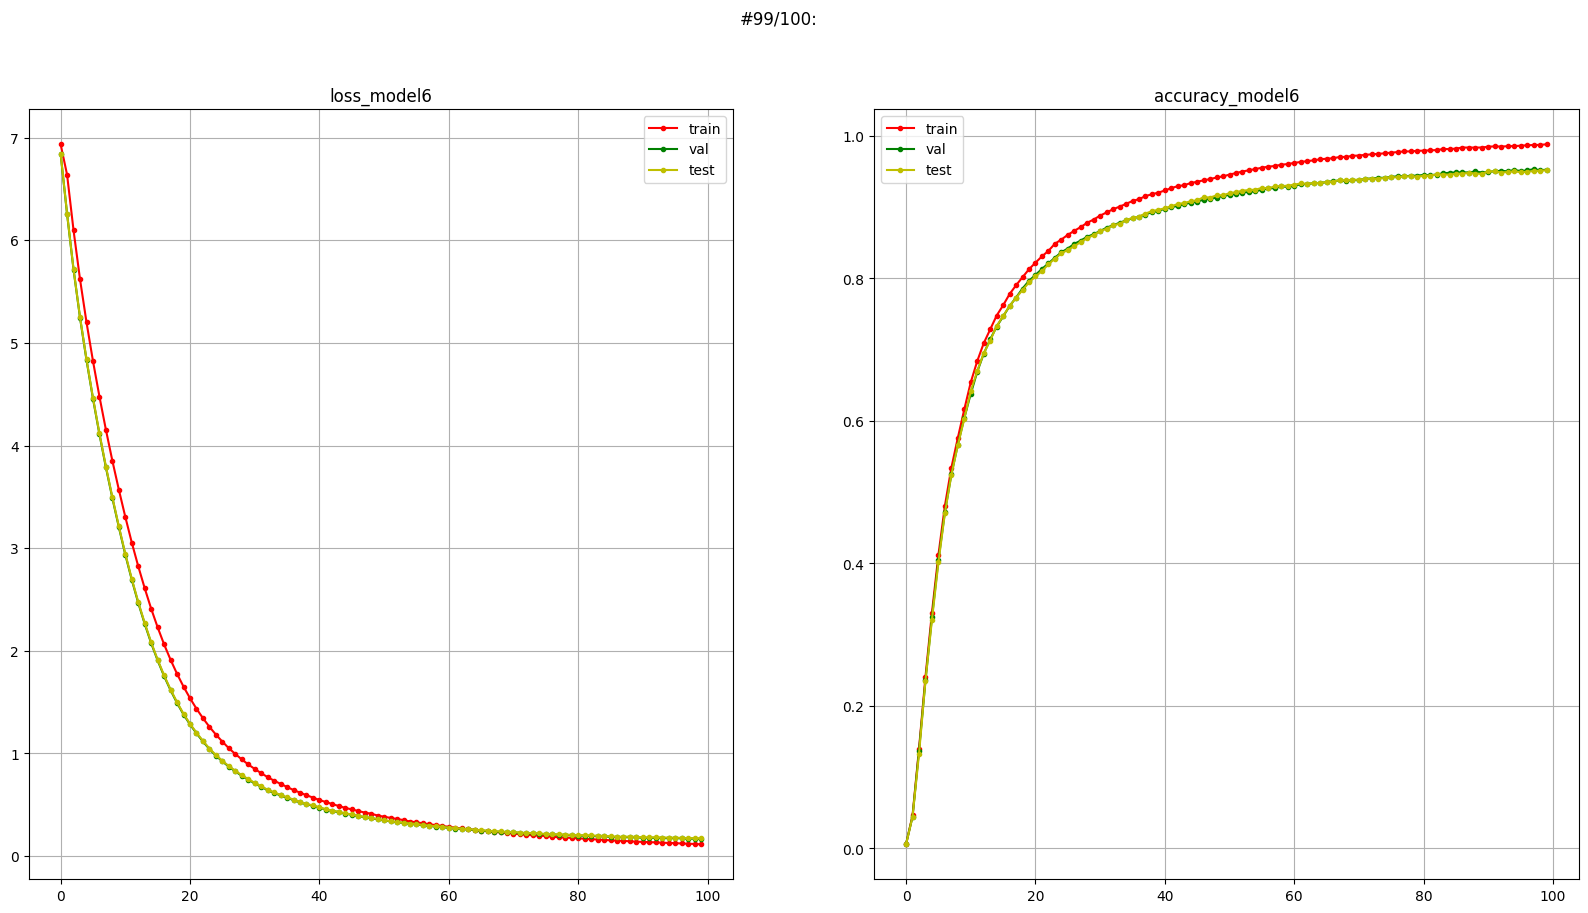

100%|█████████████████████████████████████████| 100/100 [42:39<00:00, 25.60s/it]


Learning rate set to 0.119146
0:	learn: 0.0494792	test: 0.0494792	best: 0.0494792 (0)	total: 7.74s	remaining: 4h 17m 45s
10:	learn: 0.5054253	test: 0.4928241	best: 0.4928241 (10)	total: 1m 16s	remaining: 3h 50m 44s
20:	learn: 0.6959201	test: 0.6759838	best: 0.6759838 (20)	total: 2m 26s	remaining: 3h 50m 6s
30:	learn: 0.7710648	test: 0.7495370	best: 0.7495370 (30)	total: 3m 38s	remaining: 3h 51m 1s
40:	learn: 0.8131366	test: 0.7893519	best: 0.7893519 (40)	total: 4m 51s	remaining: 3h 52m 7s
50:	learn: 0.8368200	test: 0.8118634	best: 0.8118634 (50)	total: 6m 3s	remaining: 3h 51m 19s
60:	learn: 0.8550203	test: 0.8276620	best: 0.8276620 (60)	total: 7m 13s	remaining: 3h 49m 25s
70:	learn: 0.8679687	test: 0.8390625	best: 0.8390625 (70)	total: 8m 21s	remaining: 3h 46m 51s
80:	learn: 0.8780961	test: 0.8491898	best: 0.8491898 (80)	total: 9m 25s	remaining: 3h 43m 23s
90:	learn: 0.8881655	test: 0.8570023	best: 0.8570023 (90)	total: 10m 30s	remaining: 3h 40m 22s
100:	learn: 0.8977720	test: 0.864699

  0%|                                                     | 0/2 [00:00<?, ?it/s]

Learning rate set to 0.119146
0:	learn: 0.0281395	test: 0.0280093	best: 0.0280093 (0)	total: 6.92s	remaining: 3h 50m 23s
10:	learn: 0.4671441	test: 0.4539931	best: 0.4539931 (10)	total: 1m 18s	remaining: 3h 57m 22s
20:	learn: 0.7136863	test: 0.6978009	best: 0.6978009 (20)	total: 2m 36s	remaining: 4h 5m 8s
30:	learn: 0.7913484	test: 0.7712384	best: 0.7712384 (30)	total: 3m 48s	remaining: 4h 2m 14s
40:	learn: 0.8333623	test: 0.8122106	best: 0.8122106 (40)	total: 5m 4s	remaining: 4h 2m 28s
50:	learn: 0.8556858	test: 0.8335648	best: 0.8335648 (50)	total: 6m 18s	remaining: 4h 52s
60:	learn: 0.8726997	test: 0.8484375	best: 0.8484375 (60)	total: 7m 29s	remaining: 3h 58m
70:	learn: 0.8859954	test: 0.8593750	best: 0.8593750 (70)	total: 8m 40s	remaining: 3h 55m 36s
80:	learn: 0.8953848	test: 0.8688079	best: 0.8688079 (80)	total: 9m 51s	remaining: 3h 53m 26s
90:	learn: 0.9033131	test: 0.8751736	best: 0.8751736 (89)	total: 11m	remaining: 3h 50m 45s
100:	learn: 0.9110822	test: 0.8813657	best: 0.881

 50%|███████████████████                   | 1/2 [3:45:08<3:45:08, 13508.51s/it]

Learning rate set to 0.119146
0:	learn: 0.0283131	test: 0.0284144	best: 0.0284144 (0)	total: 6.8s	remaining: 3h 46m 31s
10:	learn: 0.5088976	test: 0.4907986	best: 0.4907986 (10)	total: 1m 14s	remaining: 3h 43m 29s
20:	learn: 0.7242911	test: 0.7071759	best: 0.7071759 (20)	total: 2m 24s	remaining: 3h 47m 30s
30:	learn: 0.7980613	test: 0.7780093	best: 0.7780093 (30)	total: 3m 35s	remaining: 3h 47m 51s
40:	learn: 0.8336516	test: 0.8114005	best: 0.8114005 (40)	total: 4m 48s	remaining: 3h 50m 2s
50:	learn: 0.8557002	test: 0.8338542	best: 0.8338542 (50)	total: 5m 59s	remaining: 3h 49m 9s
60:	learn: 0.8719184	test: 0.8482639	best: 0.8482639 (60)	total: 7m 9s	remaining: 3h 47m 26s
70:	learn: 0.8846644	test: 0.8595486	best: 0.8595486 (70)	total: 8m 19s	remaining: 3h 46m 8s
80:	learn: 0.8947338	test: 0.8690394	best: 0.8690394 (80)	total: 9m 28s	remaining: 3h 44m 27s
90:	learn: 0.9046730	test: 0.8772569	best: 0.8772569 (90)	total: 10m 37s	remaining: 3h 42m 48s
100:	learn: 0.9123843	test: 0.8839699

100%|████████████████████████████████████████| 2/2 [7:28:51<00:00, 13465.82s/it]


Learning rate set to 0.119146
0:	learn: 0.0285590	test: 0.0287037	best: 0.0287037 (0)	total: 6.78s	remaining: 3h 46m 3s
10:	learn: 0.5086950	test: 0.4914931	best: 0.4914931 (10)	total: 1m 14s	remaining: 3h 43m 51s
20:	learn: 0.7129051	test: 0.6951968	best: 0.6951968 (20)	total: 2m 24s	remaining: 3h 46m 18s
30:	learn: 0.7894965	test: 0.7678241	best: 0.7678241 (30)	total: 3m 36s	remaining: 3h 49m 15s
40:	learn: 0.8268663	test: 0.8027199	best: 0.8027199 (40)	total: 4m 49s	remaining: 3h 50m 48s
50:	learn: 0.8497541	test: 0.8268519	best: 0.8268519 (50)	total: 6m 1s	remaining: 3h 50m 1s
60:	learn: 0.8669126	test: 0.8439815	best: 0.8439815 (60)	total: 7m 11s	remaining: 3h 48m 30s
70:	learn: 0.8783565	test: 0.8538773	best: 0.8538773 (70)	total: 8m 18s	remaining: 3h 45m 51s
80:	learn: 0.8892216	test: 0.8659722	best: 0.8659722 (80)	total: 9m 29s	remaining: 3h 44m 53s
90:	learn: 0.9001157	test: 0.8743634	best: 0.8743634 (90)	total: 10m 39s	remaining: 3h 43m 33s
100:	learn: 0.9084201	test: 0.88125

In [9]:
dataset_folder = 'aloi'
metric = accuracy_score

data_model, data_cb = DataLoadAndScale(dataset_folder, normalizer='standard')
results_models_learning = LearnNModels(6, Transformer, ft_transformer_params, optimizer_params, data_model, train_params, metric)
gc.collect()
torch.cuda.empty_cache()
results_cb_learning = CatBoostNLearning(results_models_learning, CatBoostClassifier, catboost_params, data_cb, metric, N=2, ensemble_size=2)

In [10]:
PrintResults(results_models_learning, results_cb_learning)

model_0_metric : 0.9515740740740741
distill_0 : 0.9452777777777778 ---------> 0.9475925925925925
model_1_metric : 0.9514351851851852
distill_1 : 0.9452777777777778 ---------> 0.9467592592592593
averaged ensembles accuracy :  0.946604938271605
